In [70]:
import spacy
import os
import xml.etree.ElementTree as ET
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from spacy import displacy
import scipy.stats

In [53]:
from spacy.tokens import Doc
# Tokenize only on whitespace to compare spacy tagger with sparv's tags
class WhitespaceTokenizer:
    def __init__(self, vocab):
        self.vocab = vocab

    def __call__(self, text):
        words = text.split(" ")
        return Doc(self.vocab, words=words)

nlp = spacy.load(os.path.join("..", "sv_model_upos", "sv_model0", "sv_model_upos0-0.0.0"))
#nlp.tokenizer = WhitespaceTokenizer(nlp.vocab)

In [54]:
doc = nlp("Den snabba bruna räven hoppar över den lata hunden.")
for token in doc:
    print(token.text, token.tag_, token.dep_, token.is_stop,[child for child in token.children])

Den DET det True []
snabba ADJ amod False []
bruna ADJ amod False []
räven NOUN nsubj False [Den, snabba, bruna]
hoppar VERB ROOT False [räven, hunden, .]
över ADP case True []
den DET det True []
lata ADJ amod False []
hunden NOUN obl False [över, den, lata]
. PUNCT punct False []


In [55]:
displacy.render(doc, style="dep", jupyter=True)

In [56]:
for token in doc: 
    print(token, [
        ('((%s))' if t is token else '%s') % t.text
        for t in token.subtree
    ])

Den ['((Den))']
snabba ['((snabba))']
bruna ['((bruna))']
räven ['Den', 'snabba', 'bruna', '((räven))']
hoppar ['Den', 'snabba', 'bruna', 'räven', '((hoppar))', 'över', 'den', 'lata', 'hunden', '.']
över ['((över))']
den ['((den))']
lata ['((lata))']
hunden ['över', 'den', 'lata', '((hunden))']
. ['((.))']


In [57]:
for sent in doc.sents:
    print(sent.root, list(sent.root.lefts), list(list(sent.root.lefts)[0].children))

hoppar [räven] [Den, snabba, bruna]


In [58]:
def processDoc(doc):
    sentence = list(doc.sents)[0]
    root = sentence.root
    print("Sentence: ", sentence)
    print("Root: ", root)
    print(numWords(root))
      
def recurseTokens(token): 
    print("Processing token: ", token)
    if(list(token.children) == []): 
        print("Leaf node")
        return token
    print("Left tokens: ", [recurseTokens(t) for t in token.lefts], "of token", token)
    print("Right tokens: ", [recurseTokens(t) for t in token.rights], "of token", token)
    
def numWords(token):
    if(len(list(token.children))==0): return 1
    return 1 + sum([numWords(c) for c in token.children])

In [59]:
processDoc(doc)

Sentence:  Den snabba bruna räven hoppar över den lata hunden.
Root:  hoppar
10


In [93]:
# Look at distribution of sentence lengths across languages/times
"""
    Process: pass in the function that will process individual sentences
    Returns whatever process returns
"""
def traverseSwed(filepath, process):
    parser = ET.iterparse(file_path, events=('start','end'))
    parser = iter(parser)
    event, root = next(parser)

    words = ""
    pos = []
    sum_overlaps= 0 
    num_para = 0
    i = 0
    ag = []
    for event, elem in parser:
        if elem.tag == "w":
            if event == "end":
                #print(elem.attrib['pos'])
                words +=  elem.text + " "
                pos.append(elem.attrib['pos'])
                elem.clear()
            root.clear()
        if elem.tag == "sentence" and event=="end":
            words = words.strip()
            if len(words) == 0: continue
            doc = nlp(words)
            ag += [process(doc)]
            
            words = ""
            pos = []
            i += 1
        if i == 10000: break
    return ag
            
def traverseFin(filepath, process):
    ag = []
    num_sentences = 0
    with open(file_path) as reader:
        words = []
        pos = []
        for line in reader:
            if num_sentences == 10000: return sum_overlaps / num_sentences
            # Start of sentence
            if line[:9] == "<sentence": 
                #print("start sentence")
                words = []
                pos_spacy=pos_sparv=pos=[]
            # End of sentence
            if line[:11] == "</sentence>": 
                if(len(words)) == 0: continue
                sent = " ".join(words)
                # print(words)
                doc = nlp(sent)
                ag += [process(doc)]
                
                num_sentences += 1
            # Split up by sentence
            # If at a text line and not just tags
            if line[0] != "<": 
                wordInfo = line.split()
                #print(wordInfo)
                words += [wordInfo[0]]
                pos += [wordInfo[1]]
            if num_sentences == 10000: break
    
    return ag

def sentenceLength(doc):
    # print(doc, len(doc))
    return(len(doc))

In [62]:
file_path = os.path.join("/share/magpie/datasets/Swedish", "kubhist2","kubhist2-carlscronaswekoblad-1870.xml")
lengthsSwe = traverseSwed(file_path, sentenceLength)

file_path = os.path.join("/share/magpie/datasets/Swedish", "klk-sv-1771-1879-vrt", "klk-sv-1870.vrt")
lengthsFin = traverseFin(file_path, sentenceLength)

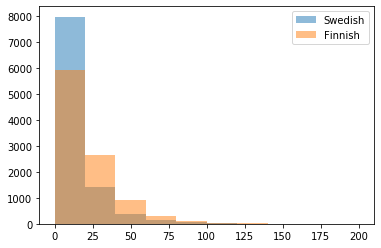

In [76]:
plt.hist(lengthsSwe, range=(0,200), alpha=0.5, label="Swedish")
plt.hist(lengthsFin, range=(0,200), alpha=0.5, label="Finnish")
plt.legend()
plt.show()

In [82]:
print("Swedish sentence length stats: ", scipy.stats.describe(lengthsSwe))
print("\nFinnish sentence length stats: ", scipy.stats.describe(lengthsFin))
print("\nIndependence t-test: ", scipy.stats.ttest_ind(lengthsFin, lengthsSwe, equal_var=False))

Swedish sentence length stats:  DescribeResult(nobs=10000, minmax=(0, 254), mean=12.352, variance=280.048300830083, skewness=3.334573847587559, kurtosis=18.41410516155351)

Finnish sentence length stats:  DescribeResult(nobs=10000, minmax=(1, 390), mean=21.1028, variance=478.29566172617257, skewness=3.396140581473916, kurtosis=25.966390131941175)

Independence t-test:  Ttest_indResult(statistic=31.777127855076248, pvalue=7.054680797823418e-216)


In [ ]:
# Look at evoluion of a single Swedish newspaper
file_path = os.path.join("/share/magpie/datasets/Swedish", "kubhist2","kubhist2-carlscronaswekoblad-1760.xml")
lengthsSweOld = traverseSwed(file_path, sentenceLength)

file_path = os.path.join("/share/magpie/datasets/Swedish", "kubhist2","kubhist2-carlscronaswekoblad-1870.xml")
lengthsSweNew = traverseSwed(file_path, sentenceLength)

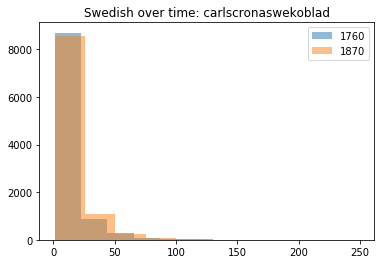

In [95]:
plt.hist(lengthsSweOld, alpha=0.5, label="1760")
plt.hist(lengthsSweNew, alpha=0.5, label="1870")
plt.legend()
plt.title("Swedish over time: carlscronaswekoblad")
plt.show()

In [98]:
print("1760 sentence length stats: ", scipy.stats.describe(lengthsSweOld))
print("\n1870 sentence length stats: ", scipy.stats.describe(lengthsSweNew))
print("\nIndependence t-test: ", scipy.stats.ttest_ind(lengthsSweOld, lengthsSweNew, equal_var=False))

1760 sentence length stats:  DescribeResult(nobs=10000, minmax=(1, 216), mean=11.2034, variance=240.31085952595257, skewness=3.9448220025447687, kurtosis=23.270512026475934)

1870 sentence length stats:  DescribeResult(nobs=10000, minmax=(1, 249), mean=12.8499, variance=274.01337132713275, skewness=3.311028795005375, kurtosis=18.210123888505795)

Independence t-test:  Ttest_indResult(statistic=-7.2601106942866505, pvalue=4.010034402096165e-13)


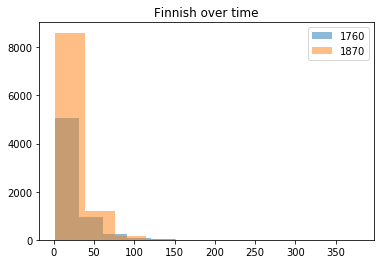

1771 sentence length stats:  DescribeResult(nobs=6336, minmax=(1, 300), mean=18.994318181818183, variance=533.0913647126354, skewness=3.07681277489981, kurtosis=16.30294535111697)

1870 sentence length stats:  DescribeResult(nobs=10000, minmax=(1, 379), mean=20.3622, variance=450.1412252825283, skewness=3.390791111858626, kurtosis=26.242927905349074)

Independence t-test:  Ttest_indResult(statistic=-3.806270608651313, pvalue=0.00014174407825511128)


In [104]:
# Look at evoluion across Finnish
file_path = os.path.join("/share/magpie/datasets/Swedish", "klk-sv-1771-1879-vrt", "klk-sv-1782.vrt")
lengthsFinOld = traverseFin(file_path, sentenceLength)

file_path = os.path.join("/share/magpie/datasets/Swedish", "klk-sv-1771-1879-vrt", "klk-sv-1870.vrt")
lengthsFinNew = traverseFin(file_path, sentenceLength)

plt.hist(lengthsFinOld, alpha=0.5, label="1760")
plt.hist(lengthsFinNew, alpha=0.5, label="1870")
plt.legend()
plt.title("Finnish over time")
plt.show()

print("1771 sentence length stats: ", scipy.stats.describe(lengthsFinOld))
print("\n1870 sentence length stats: ", scipy.stats.describe(lengthsFinNew))
print("\nIndependence t-test: ", scipy.stats.ttest_ind(lengthsFinOld, lengthsFinNew, equal_var=False))